The goal of this notebook is to calculate whether ancestry-associated guide-level dependency differences are restricted to guides with SNPs

In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(janitor)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘janitor’


The following objects are masked from ‘package:stats’:

    chisq.test, fisher.test




In [2]:
#First, load in the guide-level data
setwd("/home/jupyter/Ancestry/gwas")
replicate.map = read.table("internal-21q4_v9-achilles-replicate-map.csv", header = T, sep = ",")
guide.map = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",")
logfc = read.table("internal-21q4_v9-achilles-logfold-change.csv", header = T, sep = ",", check.names = FALSE)

In [3]:
#Load in the ancestry information and create two vectors with the EAS and EUR lines
#Load in the ancestry data
setwd("/home/jupyter/Ancestry/rfmix")
ancestry.information = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T)

#Get a vector of the EAS and EUR cell lines
eas.lines = ancestry.information %>% filter(EAS >= 0.8) %>% pull(sample)
eur.lines = ancestry.information %>% filter(EUR >= 0.8) %>% pull(sample)

In [4]:
#load in a list of the ancestry-associated genes
setwd("/home/jupyter/Ancestry/analysis/locus_specific_associations")

ancestry.associations = read.table("ancestry_locus_gene_associations.txt", sep = "\t", header = T)

#Get a list of all ancestry-associated genes
ancestry.associated.genes = ancestry.associations %>%
filter(FDR <= 0.05) %>%
pull(gene) %>%
unique()


head(ancestry.associations)
ancestry.associated.genes

,gene,pval,difference,ancestry,FDR
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,A1BG,0.07814048,0.018967685,AFR,0.9259430
2,A1CF,0.08035465,-0.035117475,AFR,0.9270243
3,A2M,0.58861022,-0.010031350,AFR,1.0000000
4,A2ML1,0.82034442,0.009988105,AFR,1.0000000
5,A3GALT2,0.96604057,0.003320528,AFR,1.0000000
6,A4GALT,0.87594000,0.004528391,AFR,1.0000000


[1] "CAAP1"    "CDKN2B"   "DMRTA1"   "EEF2"     "ELAVL2"   "IFNA10"  
 [7] "IFNA14"   "IFNA16"   "IFNA4"    "IFNA6"    "IFNA8"    "IFNB1"   
[13] "IFNE"     "IFNK"     "IZUMO3"   "MOB3B"    "MTAP"     "RESP18"  
[19] "TEK"      "ZNF236"   "ZNF407"   "ABHD5"    "ADCY3"    "BTG1"    
[25] "C22orf31" "C2orf80"  "CBFA2T2"  "CCDC102B" "CCDC74B"  "CCL3"    
[31] "CEP19"    "CHGB"     "CLPSL1"   "CLSPN"    "COX6B1"   "CSTA"    
[37] "DCN"      "DDX47"    "DND1"     "ECD"      "FAM25A"   "FCGR3A"  
[43] "FRG2C"    "GLYCTK"   "GRB2"     "HINT3"    "INCENP"   "ITGA3"   
[49] "KIAA2013" "KLF5"     "MATR3"    "MDN1"     "MRTO4"    "MYH11"   
[55] "NIT2"     "NOP56"    "NPEPPS"   "NPHS1"    "PDXDC1"   "PEX11A"  
[61] "PTPN11"   "QRICH2"   "RAB21"    "RETNLB"   "RHD"      "RIMS2"   
[67] "RPS5"     "RTP5"     "SART1"    "SLC10A5"  "SLC52A2"  "SLC5A11" 
[73] "SNAP23"   "SPATA6L"  "SRP14"    "STX4"     "STXBP3"   "TPSD1"   
[79] "TRMT61B"  "TTC4"     "TUT1"     "TXNRD1"   "UGT2B17"  "WSB2"    
[85] "ZNF675"   "ZYG11A"   "ACAN"     "DEFB108B" "EGR4"     "NKAIN4"  
[91] "NOMO2"    "PIGN"     "RPL3"     "RPP30"    "RRP7A"    "TP63"    
[97] "VRK1"     "YTHDF2"

In [5]:
#Get a list of guides that we want to keep
guides.to.keep = guide.map %>%
mutate(gene = word(gene, 1)) %>%
filter(gene %in% ancestry.associated.genes) %>%
pull(sgrna)


#First, subset the logfc data so that it only includes the guides we are interested in.
#Then collapse and average by sample
guide.level.data = logfc %>%
rename("sgrna" = 1) %>%
filter(sgrna %in% all_of(guides.to.keep)) %>%
t() %>%
row_to_names(1, remove_rows_above = FALSE) %>%
data.frame() %>%
rownames_to_column("sample") %>%
mutate(sample = plyr::mapvalues(sample, from = replicate.map$replicate_ID, to = replicate.map$DepMap_ID, warn_missing = FALSE)) %>%
melt(id = "sample") %>%
mutate(value = as.numeric(value))%>%
group_by(sample, variable) %>%
summarise(mean(value)) %>%
dcast(sample ~ variable)

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.
Using mean(value) as value column: use value.var to override.



In [6]:
###Now split the dataset into EAS and EUR cell lines and perform a t-test for each sgRNA

#Split the dataset
eur.scores = guide.level.data %>%
filter(sample %in% all_of(eur.lines))

eas.scores = guide.level.data %>%
filter(sample %in% all_of(eas.lines))

In [7]:
#First, calculate the difference in median across all of the guides
eur.median = eur.scores[2:ncol(eur.scores)] %>% apply(2, median)
eas.median = eas.scores[2:ncol(eas.scores)] %>% apply(2, median)
median.difference = eas.median - eur.median

#Now calculate a t-test between the two
t.test.vector = NULL
for(i in 2:ncol(eur.scores)){
    eas.vector = eas.scores[,i] #get a vector of sgRNA scores for the EAS lines
    eur.vector = eur.scores[,i] #get a vector of sgRNA scores for the EUR lines
    t.test.score = t.test(x = eas.vector, y = eur.vector, alternative = "two.sided")$p.value
    t.test.vector = c(t.test.vector, t.test.score)
}

In [8]:
#Now we need to figure out which guides have SNPs in them. Thankfully, we already wrote this code in "New_Which_Ancestry_Genes_Have_SNP_In_Guide"
#So let's just load it in the output from that notebook

setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
snp.positions = read.table("ancestry_guide_snp_positions.txt", sep = "\t", header = T)

#Get a list of guides that have at least one SNP
guides.with.snp = snp.positions %>%
apply(1, max)
guides.with.snp = guides.with.snp[guides.with.snp >= 1] %>% names()

In [9]:
#Now we can assemble the final data frame to make the plot
df.for.plot = cbind(median.difference, t.test.vector, colnames(guide.level.data)[2:ncol(guide.level.data)]) %>% 
data.frame() %>%
rename("sgrna" = V3) %>%
mutate("snp.code" = ifelse(sgrna %in% guides.with.snp, 1, 0)) %>%
mutate(median.difference = as.numeric(median.difference)) %>%
mutate(t.test.vector = as.numeric(t.test.vector)) %>%
mutate("fdr" = p.adjust(t.test.vector, method = "BH", n = length(t.test.vector)))
head(df.for.plot)

,median.difference,t.test.vector,sgrna,snp.code,fdr
,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
AAACTTGTGCAAGCAGAAGG,0.052611368,4.721516e-03,AAACTTGTGCAAGCAGAAGG,0,1.778291e-02
AACAATGCCCGTTTGCTGCA,-0.009758467,6.091495e-01,AACAATGCCCGTTTGCTGCA,0,7.819709e-01
AACTACCTATGACAGTGCCG,-0.016366492,6.179038e-01,AACTACCTATGACAGTGCCG,0,7.819709e-01
AAGATCGTCGACATGTACAA,-0.048750614,9.483732e-02,AAGATCGTCGACATGTACAA,1,2.171559e-01
AAGCCAGCCGAGCTCCCAGG,0.073837641,1.851952e-01,AAGCCAGCCGAGCTCCCAGG,0,3.503928e-01
AAGCGGAGACTGTACAGAAA,0.124311704,8.126406e-07,AAGCGGAGACTGTACAGAAA,0,8.397287e-06


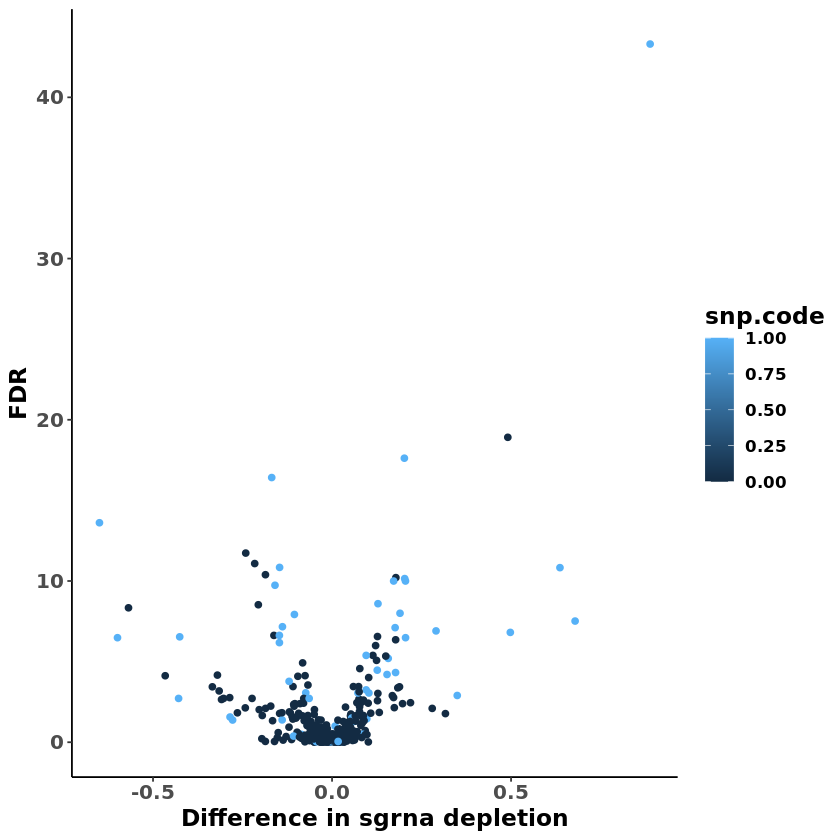

In [10]:
#Make the volcano plot
df.for.plot %>%
ggplot(aes(x = median.difference, y = -log10(fdr), color = snp.code)) +
geom_point(aes(x = median.difference, y = -log10(fdr), color = snp.code)) +
theme_bw() +

theme(
panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
legend.title = element_text(size = 14, face = "bold"),
legend.text = element_text(size = 10, face = "bold")
) +

ylab("FDR") +
xlab("Difference in sgrna depletion")

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/locus_guide_level_differential_dependency')
ggsave("locus_single_guide_volcano.pdf", width = 5, height = 3)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/locus_guide_level_differential_dependency
gsutil cp locus_single_guide_volcano.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

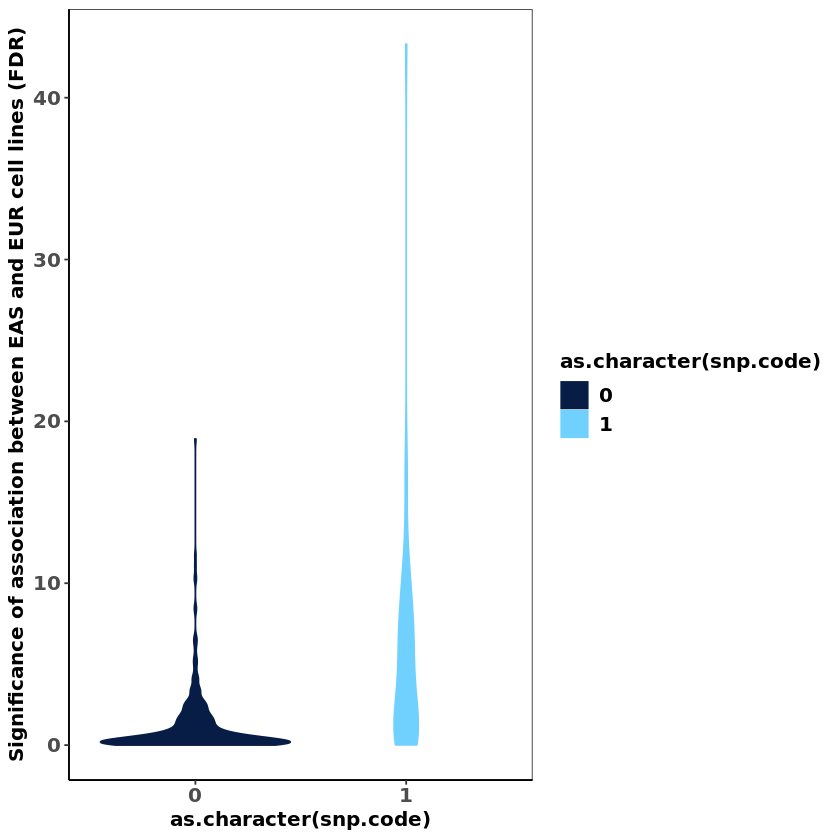

In [18]:
#Try converting it so that it is a violin plot
df.for.plot %>%
ggplot() +
geom_violin(aes(
    x = as.character(snp.code), 
    y = -log10(fdr), 
    color = as.character(snp.code), 
    fill = as.character(snp.code)
)) +

scale_fill_manual(values = c("#071d46", "#70d1ff")) +
scale_color_manual(values = c("#071d46", "#70d1ff")) +

theme_bw() +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(),
axis.line = element_line(color = "black")
) +

theme(
axis.title.x = element_text(color = "black", size = 12, face = "bold"),
axis.title.y = element_text(color = "black", size = 12, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 12,face = "bold")
) +

theme(
legend.title = element_text(size = 12, face = "bold"),
legend.text = element_text(size = 12, face = "bold")
) +

ylab("Significance of association between EAS and EUR cell lines (FDR)") 


#Export it to the google bucket
setwd('/home/jupyter/Ancestry/analysis/locus_guide_level_differential_dependency')
ggsave("locus_single_guide_violin.pdf", width = 6, height = 2)
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/locus_guide_level_differential_dependency
gsutil cp locus_single_guide_violin.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))
